# hj_reachability quickstart

Notebook dependencies:
- System: python3, ffmpeg (for rendering animations)
- Python: jupyter, jax, numpy, matplotlib, plotly, tqdm, hj_reachability

Example setup for a Ubuntu system (Mac users, maybe `brew` instead of `sudo apt`; Windows users, learn to love [WSL](https://docs.microsoft.com/en-us/windows/wsl/install-win10)):
```
sudo apt install ffmpeg
/usr/bin/python3 -m pip install --upgrade pip
pip install --upgrade jupyter jax[cpu] numpy matplotlib plotly tqdm hj-reachability
jupyter notebook  # from the directory of this notebook
```
Alternatively, view this notebook on [Google Colab](https://colab.research.google.com/github/StanfordASL/hj_reachability/blob/main/examples/quickstart.ipynb) and run a cell containing this command:
```
!pip install --upgrade hj-reachability
```

In [10]:
import jax
import jax.numpy as jnp
import numpy as np

from IPython.display import HTML
import matplotlib.animation as anim
import matplotlib.pyplot as plt
import plotly.graph_objects as go

import hj_reachability as hj

## Example system: `Air3d`

In [11]:
dynamics = hj.systems.Air3d()
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(np.array([-6., -10., 0.]),
                                                                           np.array([20., 10., 2 * np.pi])),
                                                               (51, 40, 50),
                                                               periodic_dims=2)
values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 5

solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

In [12]:
values

Array([[[ 6.6619034,  6.6619034,  6.6619034, ...,  6.6619034,
          6.6619034,  6.6619034],
        [ 6.2252655,  6.2252655,  6.2252655, ...,  6.2252655,
          6.2252655,  6.2252655],
        [ 5.795328 ,  5.795328 ,  5.795328 , ...,  5.795328 ,
          5.795328 ,  5.795328 ],
        ...,
        [ 5.795329 ,  5.795329 ,  5.795329 , ...,  5.795329 ,
          5.795329 ,  5.795329 ],
        [ 6.2252655,  6.2252655,  6.2252655, ...,  6.2252655,
          6.2252655,  6.2252655],
        [ 6.6619034,  6.6619034,  6.6619034, ...,  6.6619034,
          6.6619034,  6.6619034]],

       [[ 6.4030867,  6.4030867,  6.4030867, ...,  6.4030867,
          6.4030867,  6.4030867],
        [ 5.9561386,  5.9561386,  5.9561386, ...,  5.9561386,
          5.9561386,  5.9561386],
        [ 5.5152035,  5.5152035,  5.5152035, ...,  5.5152035,
          5.5152035,  5.5152035],
        ...,
        [ 5.5152044,  5.5152044,  5.5152044, ...,  5.5152044,
          5.5152044,  5.5152044],
        [ 5.

### `hj.step`: propagate the HJ PDE from `(time, values)` to `target_time`.

In [13]:
time = 0.
target_time = -2.8
target_values = hj.step(solver_settings, dynamics, grid, time, values, target_time)

100%|##########|  2.8000/2.799999952316284 [00:14<00:00,  5.04s/sim_s]


<Figure size 640x480 with 0 Axes>

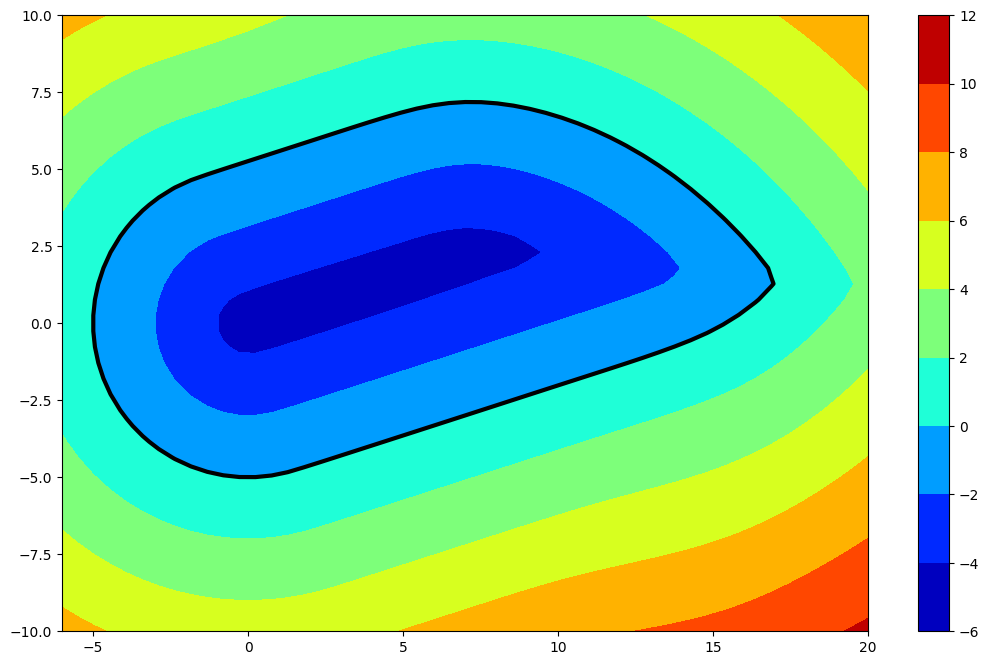

In [14]:
plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[:, :, 30].T)
plt.colorbar()
plt.contour(grid.coordinate_vectors[0],
            grid.coordinate_vectors[1],
            target_values[:, :, 30].T,
            levels=0,
            colors="black",
            linewidths=3)

In [15]:
go.Figure(data=go.Isosurface(x=grid.states[..., 0].ravel(),
                             y=grid.states[..., 1].ravel(),
                             z=grid.states[..., 2].ravel(),
                             value=target_values.ravel(),
                             colorscale="jet",
                             isomin=0,
                             surface_count=1,
                             isomax=0))

### `hj.solve`: solve for `all_values` at a range of `times` (basically just iterating `hj.step`).

In [16]:
times = np.linspace(0, -2.8, 57)
initial_values = values
all_values = hj.solve(solver_settings, dynamics, grid, times, initial_values)

100%|##########|  2.8000/2.799999952316284 [00:15<00:00,  5.65s/sim_s]


RuntimeError: Requested MovieWriter (ffmpeg) not available

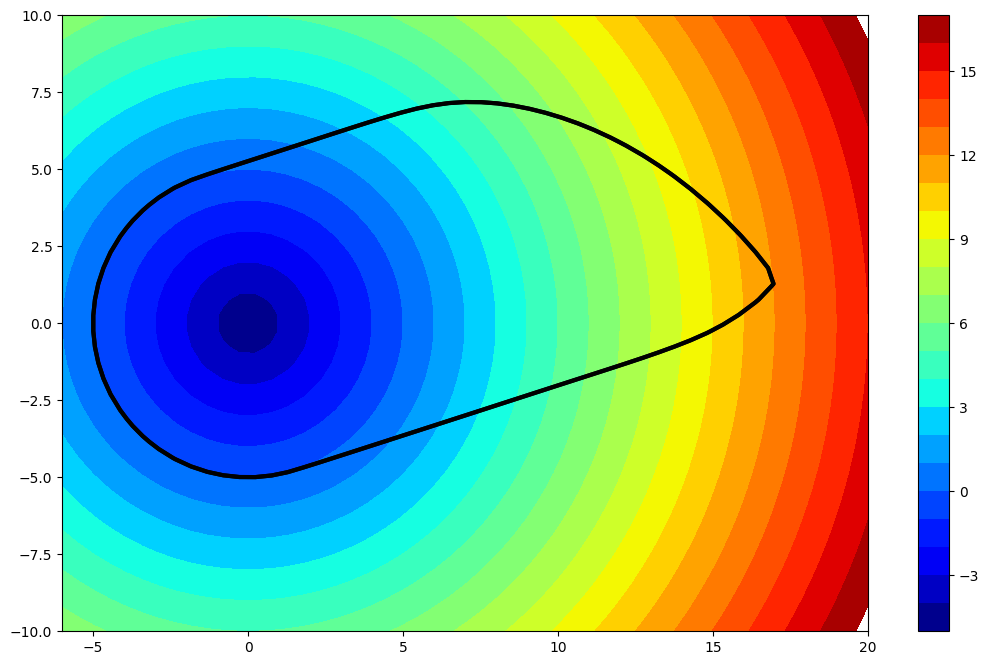

In [17]:
vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), round(vmax) - round(vmin) + 1)
fig = plt.figure(figsize=(13, 8))


def render_frame(i, colorbar=False):
    plt.contourf(grid.coordinate_vectors[0],
                 grid.coordinate_vectors[1],
                 all_values[i, :, :, 30].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(grid.coordinate_vectors[0],
                grid.coordinate_vectors[1],
                target_values[:, :, 30].T,
                levels=0,
                colors="black",
                linewidths=3)


render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation

## Defining your own dynamics: `AccelerationCurvatureCar`

In [ ]:
class AccelerationCurvatureCar(hj.ControlAndDisturbanceAffineDynamics):

    def __init__(self,
                 max_acceleration=1.,
                 max_curvature=1.,
                 max_position_disturbance=0.25,
                 control_mode="min",
                 disturbance_mode="max",
                 control_space=None,
                 disturbance_space=None):
        if control_space is None:
            control_space = hj.sets.Box(jnp.array([-max_acceleration, -max_curvature]),
                                        jnp.array([max_acceleration, max_curvature]))
        if disturbance_space is None:
            disturbance_space = hj.sets.Ball(jnp.zeros(2), max_position_disturbance)
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

    def open_loop_dynamics(self, state, time):
        _, _, v, q = state
        return jnp.array([v * jnp.cos(q), v * jnp.sin(q), 0., 0.])

    def control_jacobian(self, state, time):
        v = state[2]
        return jnp.array([
            [0., 0.],
            [0., 0.],
            [1., 0.],
            [0., v],
        ])

    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [1., 0.],
            [0., 1.],
            [0., 0.],
            [0., 0.],
        ])

In [ ]:
dynamics = AccelerationCurvatureCar()
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([-5., -5., -1., -np.pi]),
                                                                           hi=np.array([5., 5., 1., np.pi])),
                                                               (40, 40, 50, 50),
                                                               periodic_dims=3)
values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - 1

solver_settings = hj.SolverSettings.with_accuracy("low")

In [ ]:
time = 0.
target_time = -2.0
target_values = hj.step(solver_settings, dynamics, grid, time, values, target_time)

In [ ]:
go.Figure(data=go.Isosurface(x=grid.states[:, :, -1, :, 0].ravel(),
                             y=grid.states[:, :, -1, :, 1].ravel(),
                             z=grid.states[:, :, -1, :, 3].ravel(),
                             value=target_values[:, :, -1, :].ravel(),
                             colorscale='jet',
                             isomin=0,
                             surface_count=1,
                             isomax=0))